In [3]:
from model.UNet import UNet
from model.DeepLabV3Plus import DeepLabV3Plus
from model.HRNetV2 import HRNetV2
from model.AttentionUNet import AttentionUNet

import os, gc

from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [5]:
import cv2

import random

class SegmentationDataset(Dataset):
  def __init__(self, data_type, mode):    
    self.mode = mode
    self.input, self.label = [], []

    # 작업할 폴더의 경로
    path = './dataset/{0}s'.format(data_type) 

    self.input_path = '{0}/{1}/{2}'.format(path, self.mode, "data")
    self.label_path = '{0}/{1}/{2}'.format(path, self.mode, "label")

    # 폴더 안에 있는 데이터 파일들의 이름을 추출
    data_names = [name.split('.')[0] for name in os.listdir(self.input_path)]

    # 데이터 전처리
    for data_name in data_names:
        input = '{0}/{1}.tif'.format(self.input_path, data_name)
        label = '{0}/{1}.tif'.format(self.label_path, data_name[:-4] + "FGT_1024")

        self.input.append(input)
        self.label.append(label)

  def __len__(self):
    return len(self.input)

  def __getitem__(self, index):
    input = self.input[index]
    label = self.label[index]
    
    # 이미지 데이터 불러오기
    input = cv2.imread(input)
    label = cv2.imread(label, cv2.IMREAD_GRAYSCALE)
    
    # 토지 피복지도 항공위성 이미지(수도권)에서 라벨링이 10씩 곱해져있으므로 나눠줌
    label[label == 100] = 0
  
    label //= 10

    # 이미지 데이터를 텐서로 변환
    input = torch.FloatTensor(input).permute(2, 0, 1)
    label = torch.LongTensor(label).unsqueeze(dim=0) 

    # 데이터 증강 적용    
    params = transforms.RandomResizedCrop.get_params(input, scale=(0.5, 0.5), ratio=(3.0 / 4.0, 4.0 / 3.0))

    input = TF.resized_crop(input, *params, size=(512, 512), interpolation=InterpolationMode.BILINEAR)
    label = TF.resized_crop(label, *params, size=(512, 512), interpolation=InterpolationMode.NEAREST)

    label = label.squeeze(dim=0)

    # 좌우 뒤집기
    if random.random() > 0.5:
        input = TF.hflip(input)
        label = TF.hflip(label)

    # 상하 뒤집기
    if random.random() > 0.5:
        input = TF.vflip(input)
        label = TF.vflip(label)

    return input, label

In [6]:
train_dataset   = SegmentationDataset('all', 'train')
test_dataset    = SegmentationDataset('all', 'test')

In [7]:
trained_model_path = "./trained"

def train(model : nn.Module, dataset, num_epoch = 10, lr=0.001):
    if not hasattr(model, "current_epoch"): model.current_epoch = 0

    dataloader = DataLoader(dataset, batch_size=8, shuffle=True) 

    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(model.current_epoch, model.current_epoch + num_epoch):
        print("# | Epoch - {0:03d} / {1:03d} | #".format(epoch + 1, model.current_epoch + num_epoch))
        print("=========================")
        
        model.train()
        
        costs = []
        
        # 학습 진행
        for batch in tqdm(dataloader, desc="Batch Processed"):
            input, label = batch

            input = input.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            hypothesis = model(input)
            
            cost = loss_func(hypothesis, label)

            cost.backward()
            optimizer.step()

            costs.append(cost.item())

        print('Current Average Loss - {0:f}'.format(np.mean(costs)))

        # Loss를 분석하기 위해 저장
        with open("{0}/{1}/log.txt".format(trained_model_path, model.__class__.__name__), 'a+') as file:
            file.write('Epoch #{0:05d} Average Loss - {1:f}\n'.format(epoch + 1, np.mean(costs)))

        # 모델 파일 저장
        if (epoch + 1) % 5 == 0:
            path = "{0}/{1}/epoch_{2:05d}.pt".format(trained_model_path, model.__class__.__name__, epoch + 1)
            
            torch.save(model.state_dict(), path)

            print("모델 파일({0}) 저장됨\n".format(path))
    
    torch.cuda.empty_cache()
    gc.collect()

In [8]:
def load_trained_model(model : nn.Module, epoch):
    model.load_state_dict(torch.load('{0}/{1}/epoch_{2:05d}.pt'.format(trained_model_path, model.__class__.__name__, epoch)))

    model.current_epoch = epoch

In [9]:
num_classes = 9
num_epoch = 100

torch.cuda.empty_cache()
gc.collect()

#model1 = UNet(num_classes=num_classes).to(device)
#train(model1, train_dataset, num_epoch)

model2 = DeepLabV3Plus(num_classes=num_classes).to(device)
train(model2, train_dataset, num_epoch)

#model3 = HRNetV2(num_classes=num_classes).to(device)
#train(model3, train_dataset, num_epoch)

#model4 = AttentionUNet(num_classes=num_classes).to(device)
#train(model4, train_dataset, num_epoch)

231

In [10]:
model1 = UNet(num_classes=num_classes).to(device)
model2 = DeepLabV3Plus(num_classes=num_classes).to(device)
model3 = HRNetV2(num_classes=num_classes).to(device)

load_trained_model(model1, 100)
load_trained_model(model2, 100)
load_trained_model(model3, 100)

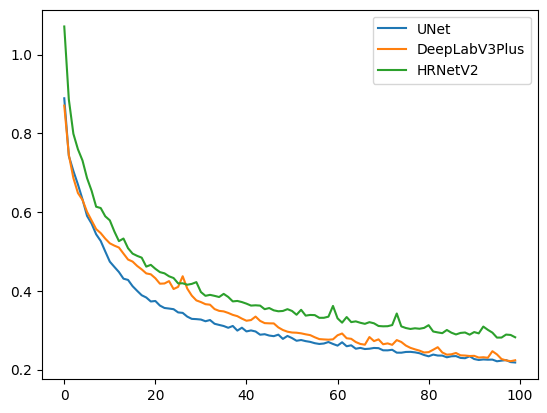

In [11]:
# Loss 분석
models = [model1, model2, model3]

for model in models:
    with open("{0}/{1}/log.txt".format(trained_model_path, model.__class__.__name__), 'r+') as file:
        lines = file.readlines()

        plt.plot([float(line.split('-')[1]) for line in lines], label=model.__class__.__name__)
        
plt.legend()
plt.show()

In [12]:
# 테스트 할 모델을 선택해주세요!
models = [model1.cpu(), model2.cpu(), model3.cpu()]

dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True) 

class_color = np.array([[255, 255, 255], [11, 190, 255], [7, 86, 251], [110, 0, 255], [236, 56, 131], [255, 134, 58], [0, 255, 94], [121, 59, 255], [173, 255, 59]], np.uint8)

for batch in dataloader:
    input, label = batch

    result = []
    
    for model in models:
        model.eval()

        with torch.no_grad(): 
            predict = torch.argmax(model(input[0].unsqueeze(dim=0)), dim=1).permute(1, 2, 0).numpy().astype(np.uint8).squeeze()
            r_label = label[0].numpy().astype(np.uint8)
            r_input = input[0].permute(1, 2, 0).numpy().astype(np.uint8)
            
            image_pred = class_color[predict]
            image_label = class_color[r_label]

            result.append(cv2.hconcat((r_input, image_label, image_pred)))
        
    cv2.imshow("result", cv2.resize(cv2.vconcat(result), None, fx=0.5, fy=0.5))

    cv2.waitKey(0)
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [13]:
cv2.destroyAllWindows()

In [ ]:
def test(model : nn.Module, dataset):
  dataloader = DataLoader(dataset, batch_size=1, shuffle=True) 

  model.to(device).eval()
  
  mIoUs = []

  with torch.no_grad():
    for batch in tqdm(dataloader, desc="Test Processed"):
        input, label = batch

        input = input.to(device)

        predict = torch.argmax(model(input[0].unsqueeze(dim=0)), dim=1).cpu().permute(1, 2, 0).numpy().astype(np.uint8).squeeze()
        r_label = label[0].cpu().numpy().astype(np.uint8)
        
        # mIoU 계산
        category = (r_label * num_classes + predict)

        confusion = np.bincount(category.ravel(), minlength=num_classes * num_classes).reshape(num_classes, num_classes)

        mIoU = []

        for i in range(num_classes):
           v_i = confusion[i, i]
           v_u = (np.sum(confusion[i, :]) + np.sum(confusion[:, i]) - v_i)

           mIoU.append(v_i / v_u if v_u != 0 else np.nan)
    
        mIoUs.append(np.nanmean(mIoU))
    
    print('mIoU - {0:f}'.format(np.mean(mIoUs)))
        
test(model3, test_dataset)

Test Processed: 100%|██████████| 2640/2640 [01:27<00:00, 30.29it/s]

mIoU - 0.604807
